# Introduction

The notebook is devoted to cross-selling investigation with granular actuarial background. Techncially, I aim on testing some different methods by use of logistic link for the binary response.

**Majority of the code was hidden, click at right to uncover it.**

**If you are interested only in actuarial sciences, skip the code. If you aim only on understanding modeling, skip actuarial background passages.**

# 1.Actuarial background

This data set is especially interesting, as it enables us to perform the analysis considered to be quite advanced in actuarial pricing world. The investigation which we aim to perfom belongs to non-life part of the insurance business, and the department responsible for this operation is Pricing Team in insurance company. Lines of insurance business belonging to this segment:

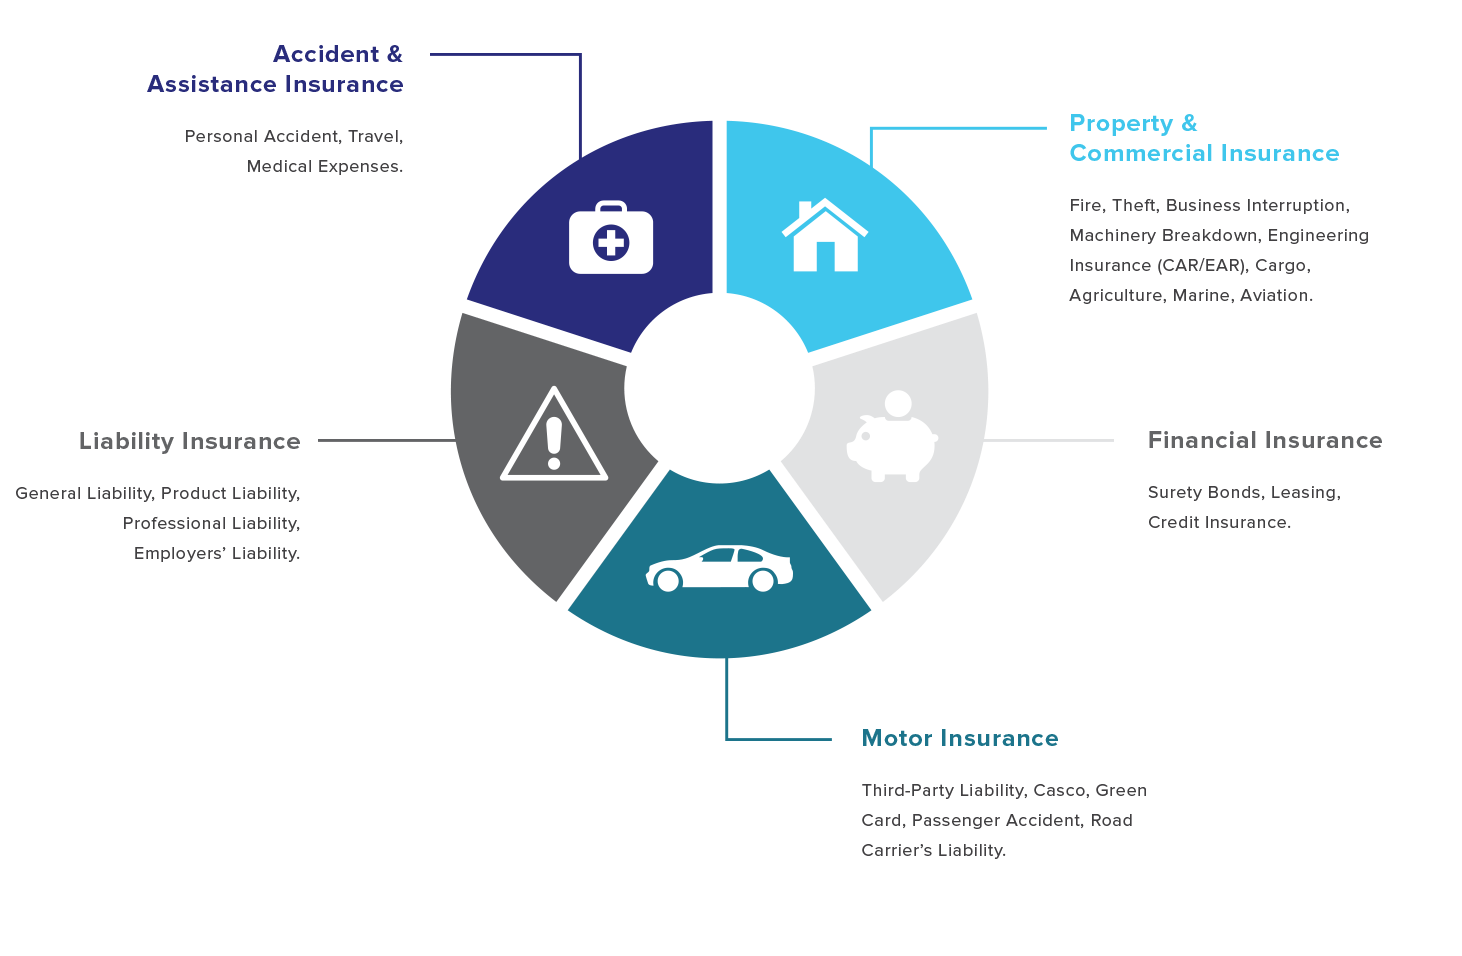

In this analysis, we have in our portfolio approximately 400.000 policyholders with health insurance. The policyholders in this data set are then already our clients. What every insurance company aims to do is to broaden its portfolio by selling its customers another product from their offer. 

**As the product is sold between segments, we call it 'cross-selling' as noted in the name of the data.**

Furthermore, we usually divide our protfolio into:
* Renewals business - policyholders who just renew policy
* New business - policyholders who will have policy from us first time

In this cross-selling investigation, we don not have any information about our exisiting vehicle portfolio. Hence, this is purely new business analysis. 

Another important point is that new business modeling is always connected by so-called "competitors' models". Why? Our company is always one out of many present in the insurance market, so we can't treat it as lonely island. What is usually done is fitting tariff of our competitors and comparing our tariff against their ones. Hence, in this case we won't produce perfectly usable strcuture regardless the level of prediction. However, this great data enables us anyway to perform very absorbing task.

# 2.Data cleaning

I will perform classic set of operations starting from libraries loading, data loading, finishing at compact cleaning. I add simple comments at the end of code stages to keep it self-explonatory.

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib
import seaborn as sns
import holoviews as hv
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.utils import resample,shuffle
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from mlxtend.preprocessing import minmax_scaling
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF
from holoviews import opts
from sklearn import metrics, mixture, cluster, datasets
from sklearn.mixture import GaussianMixture
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, roc_curve, auc
hv.extension('bokeh')

print('Libraries correctly loaded')

In [ ]:
df_path = "../input/health-insurance-cross-sell-prediction/train.csv"
df_test_path = "../input/health-insurance-cross-sell-prediction/train.csv"
df = pd.read_csv(df_path)
df_test = pd.read_csv(df_test_path)

print('Number of rows: '+ format(df.shape[0]) +', number of features: '+ format(df.shape[1]))

In [ ]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

Hence, no NA's corrections are needed. Next, I check my categorical variables:

In [ ]:
CategoricalVariables

Definitely, 'vehicle age' has to be transformed to numeric structure.

In [ ]:
df.Vehicle_Age.unique()

In [ ]:
Vehicle_Age_map  = {'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}

df['Vehicle_Age'] = df['Vehicle_Age'].map(Vehicle_Age_map)
df=df.set_index("id")

C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

df.head()

The data is ready for some checks and analysis. Some functions for the future:

In [ ]:
def highlight_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)

def ExtractColumn(lst,j): 
    return [item[j] for item in lst] 

# 3.Data analysis

First, I would like to granularly describe what I observe in the data and how I will approach it:

In [ ]:
coldict = {'Gender':'lightcoral','Age':'lightcoral', 'Driving_License':'lightsalmon', 'Region_Code':'lightsalmon', 'Previously_Insured':'lightsalmon'
           , 'Vehicle_Age':'lightsalmon', 'Vehicle_Damage':'lightsalmon', 'Annual_Premium':'lightsalmon', 'Policy_Sales_Channel':'tomato'
           ,'Vintage':'tomato','Response':'darksalmon'}
df.iloc[0:5].style.apply(highlight_cols, coldict=coldict)

1. General policyholder variables regarding any insurance type
2. Variables for car insurance portfolio
3. Features regarding selling methodology
4. The binary response variable informing whether the health policyholder is interested in our car product or not

**Dummy transformation**

I have only two vategorical variables: Gender and Vehicle_Damage, each of them has only 2 levels. Transforming them I will receive only 4 new variables isntead of 2 which are currently present.

In [ ]:
df_dummy = pd.get_dummies(df[CategoricalVariables], columns=CategoricalVariables)
df_numeric = df[NumericVariables]
df_final = pd.merge(df_numeric,df_dummy,on='id')

response = ['Response']
VariablesNoTarget = [x for x in df_final.columns if x not in response]
print("Dummy transformation was successful")

In [ ]:
coldict_dummy = {'Gender_Female':'lightcoral','Gender_Male':'lightcoral','Age':'lightcoral', 'Driving_License':'lightsalmon' 
                   ,'Region_Code':'lightsalmon', 'Previously_Insured':'lightsalmon'
                   , 'Vehicle_Age':'lightsalmon', 'Vehicle_Damage_No':'lightsalmon', 'Vehicle_Damage_Yes':'lightsalmon', 'Annual_Premium':'lightsalmon'
                   , 'Policy_Sales_Channel':'tomato','Vintage':'tomato','Response':'darksalmon'}

df_final = df_final[['Age','Gender_Female','Gender_Male','Driving_License','Previously_Insured','Vehicle_Age','Region_Code','Vehicle_Damage_No'
               ,'Vehicle_Damage_Yes','Annual_Premium','Policy_Sales_Channel','Vintage','Response']]

df_final[VariablesNoTarget] = minmax_scaling(df_final, columns=VariablesNoTarget)
df_final.iloc[0:5].style.apply(highlight_cols, coldict=coldict_dummy)

**Correlation check**

I use Spearman correlation as its rank nature counter-acts for linearity assumption ([more info in my correlation notebook](https://www.kaggle.com/jjmewtw/yt-pearson-spearman-distance-corr-rv-coef)).

In [ ]:
SpearmanCorr = df_final.corr(method="spearman")
matplotlib.pyplot.figure(figsize=(10,10))
sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

The most relevant is the relation between "Response" and the rest of the variables. In this case I see some correlation betweenResponse and "Vehicle_Damage", furthermore there is a negative relation with binary "Previously_Insured" variable. Another interesting relations:
* age is strongly correalted with age of car. This is well-known in actuarial world relation that young people drive old cars
* age with sales channel, old people tend to use brokers and agents, young ones use internet
* previously insured is correlated with age and vehicle age. Young people tend to change insurer often
* previously insured with vehicle damage, indeed a lot of polocyholders change the insurer while they correspond to big risk
* **vehicle age and policy sales channel - this is interesting spurious effect. The real underlying effect is relation between age and sales channel, indirectly influencing numbers for age of vehicle**

**Factors distributions**

The distribution of factors is relevant for real understanding underlying data. Actuaries tend also to fit statistical distributions ([more](https://en.wikipedia.org/wiki/Probability_density_function)) to particular factors.

In [ ]:
age = hv.Distribution(df['Age'],label="Age").opts(color="red")
reg = hv.Distribution(df['Region_Code'],label="Region_Code").opts(color="green")
prem = hv.Distribution(df['Annual_Premium'],label="Annual_Premium").opts(color="yellow")
chan = hv.Distribution(df['Policy_Sales_Channel'],label="Policy_Sales_Channel").opts(color="blue")
vehage = hv.Distribution(df['Vehicle_Age'],label="Vehicle_Age").opts(color="purple")
vin = hv.Distribution(df['Vintage'],label="Vintage").opts(color="pink")

(age + reg + prem + chan + vehage + vin).opts(opts.Distribution(xlabel="Values", ylabel="Density", width=400, height=300,tools=['hover'],show_grid=True)).cols(3)

Age has not regular shape for non-life portfolio. It is highly skewed towards younger ages. It is hard for me to understand why it is the case, but it can be certain trend characteristic for developing countries where new generation approaches finance & health in mdoern way whereas older generations are still reluctant. Region code, sales channel and vehicle age are dispersed around some dominating points. Annyal premium has reasonable shape. Vintage is uniformly distributed, hence proably useless.

**Principial Component Analysis**

It is relevant to understand the variability in the data set. First we will apply linear method: PCA ([more information](https://www.kaggle.com/jjmewtw/total-analysis-of-pca-sparse-pca-nmf-kernel-pca)) which allows for assessment how many components suffice to cover the majority of variance in the data set. For this I look at cumulative variance explained:

In [ ]:
pca = PCA().fit(df_final[VariablesNoTarget])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(df_final[VariablesNoTarget].shape[1]),pca.explained_variance_)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance');

plt.tight_layout()
plt.show()

In [ ]:
n_PCA_90 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.9)
print("Already: " + format(n_PCA_90) + " components cover 90% of variance.")

The above operation allows us to detect how many components are needed to capture the variability at satisfying level. The shortcoming of PCA is linearity assumption, to facilitate this we can employ Kernel PCA transformation for this. By applying Hilbert space transformation, we will achieve data set where this would be not a problem anymore. However, as algorithm is computationally very heavy, I left it out:

In [ ]:
#KPCA = KernelPCA(n_components = df_final[VariablesNoTarget].shape[1], kernel="rbf", fit_inverse_transform=True, gamma=10)
#KPCA_fit = KPCA.fit(df_final[VariablesNoTarget])
#X_KPCA = KPCA.fit_transform(df_final[VariablesNoTarget])
#X_KPCA_back = KPCA.inverse_transform(X_KPCA)

I apply regular PCA with 4 components and check what variables contribute the most:

In [ ]:
pca = PCA(4).fit((df_final[VariablesNoTarget]))

X_pca=pca.transform((df_final[VariablesNoTarget])) 

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4],['1st Comp','2nd Comp','3rd Comp','4th Comp'],fontsize=10)
plt.colorbar()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],VariablesNoTarget,fontsize=10,rotation=30)
plt.tight_layout()
plt.show()

To break it down in even more readable way:

In [ ]:
PCA_vars = [0]*len(VariablesNoTarget)

for i, feature in zip(range(len(VariablesNoTarget)),VariablesNoTarget):
    x = ExtractColumn(pca.components_,i)
    if ((max(x) > 0.4) | (min(x) < -0.4)):
        if abs(max(x)) > abs(min(x)):
            PCA_vars[i] = max(x)
        else:
            PCA_vars[i] = min(x)                 
    else:
        PCA_vars[i] = 0

PCA_vars = pd.DataFrame(list(zip(VariablesNoTarget,PCA_vars)),columns=('Name','Max absolute contribution'),index=range(1,13,1))      
PCA_vars = PCA_vars[(PCA_vars['Max absolute contribution']!=0)]
PCA_vars

To sum up:
* 'age' contributes to at leat two components
* 'previously insured' contributes to at least three components
* 'veh age' performs same as 'age'
* 'vintage' dominates one and only one component 4th
* 'sales channel' contributes to at leat two components
* both 'gender' and 'vehicle damage contribute to three components

Already some information what can be useful further.

**Clustering**

The aim of this part is to create the cluster variable which will group policyholders in reasonable way. First, I aim to create so-called 'business cluster' which will cover the trends from frour variables: <Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage>. For this I will employ powerful tool called "Expectation-maximization algorithm", which belongs to clustering methods' family.

In [ ]:
df_business = df_final[['Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']]
X = df_business.values

GM_n_components = np.arange(1, 8)
GM_models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in GM_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor='w', edgecolor='r')
plt.plot(GM_n_components, [m.aic(X) for m in GM_models], label='AIC')
plt.tight_layout()
plt.legend(loc='best')
plt.xlabel('n_components');

This graph works like elbow rule, it enables us to see how many clusters are needed to lower variability in the cluster, AIC ensures that the difference is relevant statistically. Regardless the results, I want to employ this unsupervised method for classification task, so 2 clusters.

In [ ]:
GM_n_classes = 2

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full',random_state = 0)
GMcluster_fit = GMcluster.fit(df_business)
GMlabels = GMcluster_fit.predict(df_business)

print('Number of clusters: ' + format(len(np.unique(GMlabels))))

I apply 2 as number of clusters to my data and look at it in 3D:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(10, 40)
for l in np.unique(GMlabels):
    ax.scatter(X[GMlabels == l, 0], X[GMlabels == l, 1], X[GMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(GMlabels + 1)),s=20, edgecolor='k')
plt.title('Expectation-maximization algorithm for business features clustering' )

plt.show()

Three of them vastly dominante the picture. However, looking into the table, they are distributed well between 5 clusters. I merge this cluster into data:

In [ ]:
df_final[['Business_Cluster']] = list(GMlabels)

coldict_cluster_1 = {'Gender_Female':'lightcoral','Gender_Male':'lightcoral','Age':'lightcoral', 'Driving_License':'lightsalmon' 
                   ,'Region_Code':'lightsalmon', 'Previously_Insured':'lightsalmon'
                   , 'Vehicle_Age':'lightsalmon', 'Vehicle_Damage_No':'lightsalmon', 'Vehicle_Damage_Yes':'lightsalmon', 'Annual_Premium':'lightsalmon'
                   , 'Policy_Sales_Channel':'tomato','Vintage':'tomato','Response':'darksalmon','Business_Cluster':'pink'}

df_final.iloc[0:5].style.apply(highlight_cols, coldict=coldict_cluster_1)

Our 'Business cluster' joined the data. I would like to create same cluster for policyholder, and call it 'Client cluster'. I repeat the procedure.

In [ ]:
VariablesClient = [x for x in df_final[VariablesNoTarget] if x not in df_business.columns]

df_client = df_final[VariablesClient]
X = df_client.values

GMcluster_fit = GMcluster.fit(df_client)
GMlabels = GMcluster_fit.predict(df_client)

df_final[['Client_Cluster']] = list(GMlabels)

coldict_cluster_2 = {'Gender_Female':'lightcoral','Gender_Male':'lightcoral','Age':'lightcoral', 'Driving_License':'lightsalmon' 
                   ,'Region_Code':'lightsalmon', 'Previously_Insured':'lightsalmon'
                   , 'Vehicle_Age':'lightsalmon', 'Vehicle_Damage_No':'lightsalmon', 'Vehicle_Damage_Yes':'lightsalmon', 'Annual_Premium':'lightsalmon'
                   , 'Policy_Sales_Channel':'tomato','Vintage':'tomato','Response':'darksalmon','Business_Cluster':'pink','Client_Cluster':'pink'}

df_final = df_final[['Age','Gender_Female','Gender_Male','Driving_License','Previously_Insured','Vehicle_Age','Region_Code','Vehicle_Damage_No'
               ,'Vehicle_Damage_Yes','Annual_Premium','Policy_Sales_Channel','Vintage','Business_Cluster','Client_Cluster','Response']]

df_final.iloc[0:5].style.apply(highlight_cols, coldict=coldict_cluster_2)

In this chapter we enriched the data set by defining two clusters which operate on the different subsets and aim on capturing different relations. We will see whether these clusters appear to be useful in further analysis.

# 4.Basic models estimation

This part I would like to start from repeating one message: in Principial Component part we have already predefined candidates for the best performance. All models which don't select variables automatically can be fed by this list. Furthermore, to start with the topic, I will define the simplest model in the world: 'average', as the benchmark of further tools' quality.

First, I split the train data set into two parts:
* Train
* Validation

In [ ]:
Target= df_final['Response']
df_final_ = df_final.drop(['Response'],axis=1)

x_train,x_test,y_train,y_test = train_test_split(df_final_,Target,test_size=0.2,random_state=0)

In [ ]:
ModelAverage = y_train.mean()
print(str(round(ModelAverage,5)))

Precisely it means that 12% of customers are interested in this corss-selled product. Alright, we have benchmark.

**Logistic regression**

I will fit first real model, namely logistic regression looking and probability predicted by the model:

In [ ]:
GLM = LogisticRegression(solver='liblinear', random_state=0)
GLM_fit = GLM.fit(x_train, y_train)
GLM_probability = pd.DataFrame(GLM_fit.predict_proba(x_test))
GLM_probability.mean()

In [ ]:
print("We expect: " +format(round((float(GLM_probability[1].mean() * x_test.shape[0]))))+ " 1's.")

I look at means of both binary cases, on average they should be consistent with the data ones. I like the results at this stage. Next, I will investigate how predictied probabilities are translated to classification.

In [ ]:
GLM_clas = pd.DataFrame(GLM_fit.predict(x_test))
print("The rate is very low: "+ format(float(round(GLM_clas.mean(),5))) + " and translates to just: " + format(float(GLM_clas.mean() * x_test.shape[0])) + " records with 1's.")

What does it say to us? We face imbalanced data where the majority of observations fall into one out of binary levels. Solutions can be re-balancing or using cost-sensitive algorithm. Let's look at the probability distribution:

In [ ]:
GLM_Ret = hv.Distribution(GLM_probability[1],label="Probability of retention").opts(color="blue")
(GLM_Ret).opts(opts.Distribution(xlabel="Values", ylabel="Density", width=600, height=400,tools=['hover'],show_grid=True))

Alright, let me approach it differently, as the data is unbalanced I will resample it ([inspiration](https://www.kaggle.com/ayushikaushik/eda-oversampling-classification-roc-auc-score-93)):

In [ ]:
df_majority = df_final[df_final['Response']==0]
df_minority = df_final[df_final['Response']==1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=334399,random_state = 0)
balanced_df = pd.concat([df_minority_upsampled,df_majority])
balanced_df = shuffle(balanced_df)
balanced_df.Response.value_counts()

Let me repeat all the steps and check the effect:

In [ ]:
Target= balanced_df['Response']
df_final_ = balanced_df.drop(['Response'],axis=1)

x_train,x_test,y_train,y_test = train_test_split(df_final_,Target,test_size=0.2,random_state=0)

GLM = LogisticRegression(solver='liblinear', random_state=0)
GLM_fit = GLM.fit(x_train, y_train)
GLM_clas = pd.DataFrame(GLM_fit.predict(x_test))
GLM_probability = pd.DataFrame(GLM_fit.predict_proba(x_test))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, GLM_fit.predict_proba(x_test)[:,1])

plt.title('Logistic regression ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ' ,format(round(auc(fpr,tpr),5)))

Alright, this works much better. Let's continue with this approach.

In [ ]:
df_evaluation = pd.DataFrame(y_test)
df_evaluation[['GLM']] = list(GLM_fit.predict(x_test))

**Clustering**

In the chapter '3' I defined 2 different clusters: 'business cluster' and 'client cluster'. This method can be used in to ways:
* I can directly employ clusters to my data as interesting interation-type variables
* Alternatively, I can say that binary cluster should point at some pecularities differentiating between clients who would like to have policy and these reluctant ones

In [ ]:
fpr, tpr, _ = roc_curve(y_test, x_test['Client_Cluster'])

plt.title('Client Cluster ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', format(round(auc(fpr,tpr),5)))

In [ ]:
InvertClientCluster = x_test['Client_Cluster'].replace(0,-1)
InvertClientCluster = InvertClientCluster.replace(1,0)
InvertClientCluster = InvertClientCluster.replace(-1,1)
InvertClientCluster

fpr, tpr, _ = roc_curve(y_test, x_test['Business_Cluster'])

plt.title('Business Cluster ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', format(round(auc(fpr,tpr),5)))

Interesting results. Whereas business cluster has compeltely neutral performance (it is perfectly random), client cluster is already quite powerful.

**Extreme boosting**

I apply very popular but also really powerful algorithm called extreme boosting for this task as well. My cross validation was inspired by [this notebook](https://www.kaggle.com/yashvi/vehicle-insurance-eda-and-boosting-models). Please uncomment if you would like to run (approximately 40 minutes):

In [ ]:
space={ 'max_depth': hp.quniform("max_depth", 3,18,1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 300,
        'seed': 0}

def objective(space):
    clf=XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                      reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                      colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict(x_test)
    y_score = clf.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test, pred>0.5)
    Roc_Auc_Score = roc_auc_score(y_test, y_score)
    print ("ROC-AUC Score: ",Roc_Auc_Score)
    print ("SCORE: ", accuracy)
    return {'loss': -Roc_Auc_Score, 'status': STATUS_OK }

#trials = Trials()

#best_hyperparams = fmin(fn = objective,space = space,algo = tpe.suggest,max_evals = 100,trials = trials)

#print("The best hyperparameters are : ","\n")
#print(best_hyperparams)

I fit the model with the best parameters:

In [ ]:
XGB_=XGBClassifier(n_estimators = 300, max_depth = 13, gamma = 2.3408807913619945, reg_lambda = 0.3770436657913232,
                            reg_alpha = 40.0, min_child_weight=7.0,colsample_bytree = 0.5786479102658189 ,random_state = 0)
XGB_fit = XGB_.fit(x_train, y_train)
XGB_probability = XGB_fit.predict_proba(x_test)[:,1]
XGB_class = pd.DataFrame(XGB_fit.predict(x_test))

In [ ]:
df_evaluation[['XGB']] = list(XGB_fit.predict(x_test))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, XGB_probability)

plt.title('XGBoost ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', format(round(auc(fpr,tpr),5)))

AUC at this level is quite satisfying. Obviously, extreme boosting overperformed logistic regression. 

**Actuarially speaking: it's of course relevant to have models with high predictive power, however every insurer's tariff has to be transparent and possible to be explained to country's financial regulator. Hence, what is usually done is trends / importance detection by use of ML/DL methods, but the outputs are not directly applied to insurer's model but rather insight is used for GLM modeling.**

What would be done in this case: we would export importance strcuture from extreme boosting / GBM and applied findings to Generalized Linear Model / Logistic regression manually.

I hope you enjoyed the notebook. If so, please upvote.

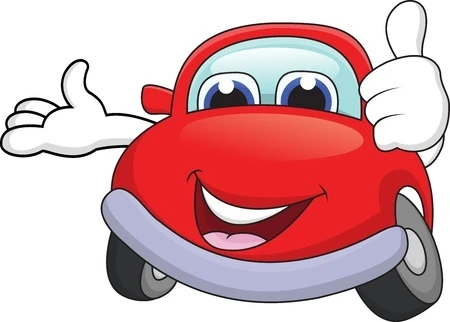